In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img 
from keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications import VGG16

# models 
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

2024-04-24 09:48:55.519663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 09:48:55.519714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 09:48:55.520690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 09:48:55.526580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 09:48:56.248365: W tensorflow/compiler/tf2

In [2]:
## create list of image files

# enter paths to all directories from which you want to cluster images
paths = ["/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_notar", "/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst"]
# change the working directory to the path where the images are located

# this list holds all the image filenames
charters = []

# iterate over files in path
for path in paths:
    with os.scandir(path) as files:
        for file in files:
            if file.name.endswith(('.png', '.jpg')):
              # adds the image files to the list
                charters.append((file.name, path.split('/')[-1]))

# save list of charters and folders
charter_p = r"/home/tschernn/becore-clustering/charter_list.pkl"

with open(charter_p,'wb') as file:
    pickle.dump(charters, file)

charters[1:-1:50]

[('wa_77d63365260e4f4f6b999bfb2dc7db88.jpg', 'writable_area_notar'),
 ('wa_605d01eaf6263feb09a898304fb45be0.jpg', 'writable_area_notar'),
 ('wa_648071cd289fe932ed545906fd8fcec2.jpg', 'writable_area_papst'),
 ('wa_cccb54fdbc93cc2756c288948c32f79e.jpg', 'writable_area_papst')]

In [3]:
### define VGG models to choose from, regular and large

## regular VGG with output layer removed

model_vgg_regular = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (224, 224, 3)))
#model_vgg_regular = Model(inputs = model_vgg_regular.inputs, outputs = model_vgg_regular.layers[-3].output)

# custom top layers
top_reg = Flatten()(model_vgg_regular.output)
top_reg = Dense(4096, activation='relu')(top_reg)
#top_reg = Dense(4096, activation='relu')(top_reg)

model_vgg_regular = Model(inputs = model_vgg_regular.input, outputs = top_reg)

## large VGG -> modified for input size 448 x 448

# weights are either imagenet or None (i.e. random initialization)
# include_top = False -> leave out flattening & fc layers

model_vgg_large = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (448, 448, 3)))

# custom top layers
top_lrg = Flatten()(model_vgg_large.output)
top_lrg = Dense(4096, activation='relu')(top_lrg)
#top_lrg = Dense(4096, activation='relu')(top_lrg)

model_vgg_large = Model(inputs = model_vgg_large.input, outputs = top_lrg)

2024-04-24 09:48:57.681200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 09:48:57.716550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 09:48:57.716812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
### choose image size (default for VGG is 224 x 224) & model
img_size = (224, 224)
model_vgg = model_vgg_regular
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2024-04-24 09:48:58.867954: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-24 09:48:58.920622: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] RESOURCE_EXHAUSTED: /tmp/tempfile-ZIMPU-c72dfa53-1600707-616d2e73fb7e9; No space left on device
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-04-24 09:48:59.144887: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.



 number of layers in VGG model: 21

 input shape: (1, 224, 224, 3)


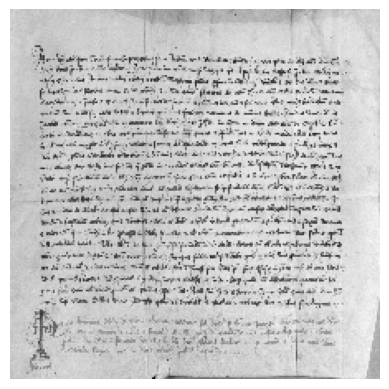

In [5]:
### visualizing the process of transforming images

# select an example for visualization
charter_dir = charters[0][1]
charter_name = charters[0][0]

img_visualize = f'{charter_dir}/{charter_name}'

# turn to resized PIL
img_visualize = load_img(img_visualize, target_size=img_size)
#plt.imshow(img_resize)

# turn to numpy array
img_visualize = np.array(img_visualize)

# access the various layers and their outputs 
vgg_layers = model_vgg.layers
vgg_input = model_vgg.input
layer_outputs_vgg = [layer.output for layer in vgg_layers]
features_vgg = Model(inputs = vgg_input, outputs = layer_outputs_vgg)

# visualize via one img
one_img_data = f'{charter_dir}/{charter_name}'

# turn to resized PIL
one_img_data = load_img(one_img_data, target_size = img_size, color_mode = "grayscale")

# turn to numpy array
one_img_data = np.array(img_visualize)
one_img_data = one_img_data[np.newaxis,...]

# get number of layers in model
extracted_vgg = features_vgg(one_img_data)
print('\n number of layers in VGG model:', len(extracted_vgg))

# get input layer
input_vgg = extracted_vgg[0]
print('\n input shape:', input_vgg.shape)
imgs = input_vgg[0,...]

# display input layer
plt.imshow(imgs[...,0], cmap='gray')
plt.axis('off')
plt.show()

In [6]:
## reshape imgs

def reshape_img(file):
    # load the image as a PIL of the chosen size
    img = load_img(file, target_size=img_size)
    # convert from 'PIL.Image.Image' to numpy array => img.shape is (224, 224, 3)
    img = np.array(img) 
    # reshape the array for the model - reshape(num_of_samples, dim 1, dim 2, channels) => img.shape is (1, 224, 224, 3)
    reshaped_img = img.reshape(1, img_size[0], img_size[1], 3)
    return reshaped_img

### save and export image array
 
imgs_list = []
for charter in charters:
    reshaped = reshape_img(f'/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/{charter[1]}/{charter[0]}')
    imgs_list.append(reshaped)
imgs_array = np.array(imgs_list)
imgs_array = imgs_array.squeeze()
imgs_array.shape

p = r"/home/tschernn/becore-clustering/img_array.pkl"

with open(p,'wb') as file:
    pickle.dump(imgs_array, file)
    print(f'Saved image arrays as {file.name}.')

Saved image arrays as /home/tschernn/becore-clustering/img_array.pkl.


In [7]:
## define feature extraction with VGG

# function returns a numpy.ndarray of shape 1, 4096
def extract_features_vgg(file, model):
    reshaped_img = reshape_img(file)
    # preprocess for VGG, i.e. convert RGB to BGR, zero-center color channels with respect to the ImageNet dataset, without scaling
    prep_img = preprocess_input(reshaped_img)
    # get the feature vector by applying VGG for feature extraction
    features = model.predict(prep_img, use_multiprocessing = True)
    return features

In [8]:
def visualize_layer_feature_map(layer):
    layer_fm = extracted_vgg[layer]

    print(f'\n layer {layer} shape:', layer_fm.shape)

    fm_no = 9
    rows = int(np.sqrt(fm_no))

    imgs = layer_fm[0,...]
    plt.figure(figsize=(20, 20))
    for n in range(fm_no):
        ax = plt.subplot(rows, rows, n+1)
        plt.imshow(imgs[...,n], cmap='gray')
        plt.axis('off')
    plt.subplots_adjust(wspace=0.01, hspace=0.01)


 layer 1 shape: (1, 224, 224, 64)


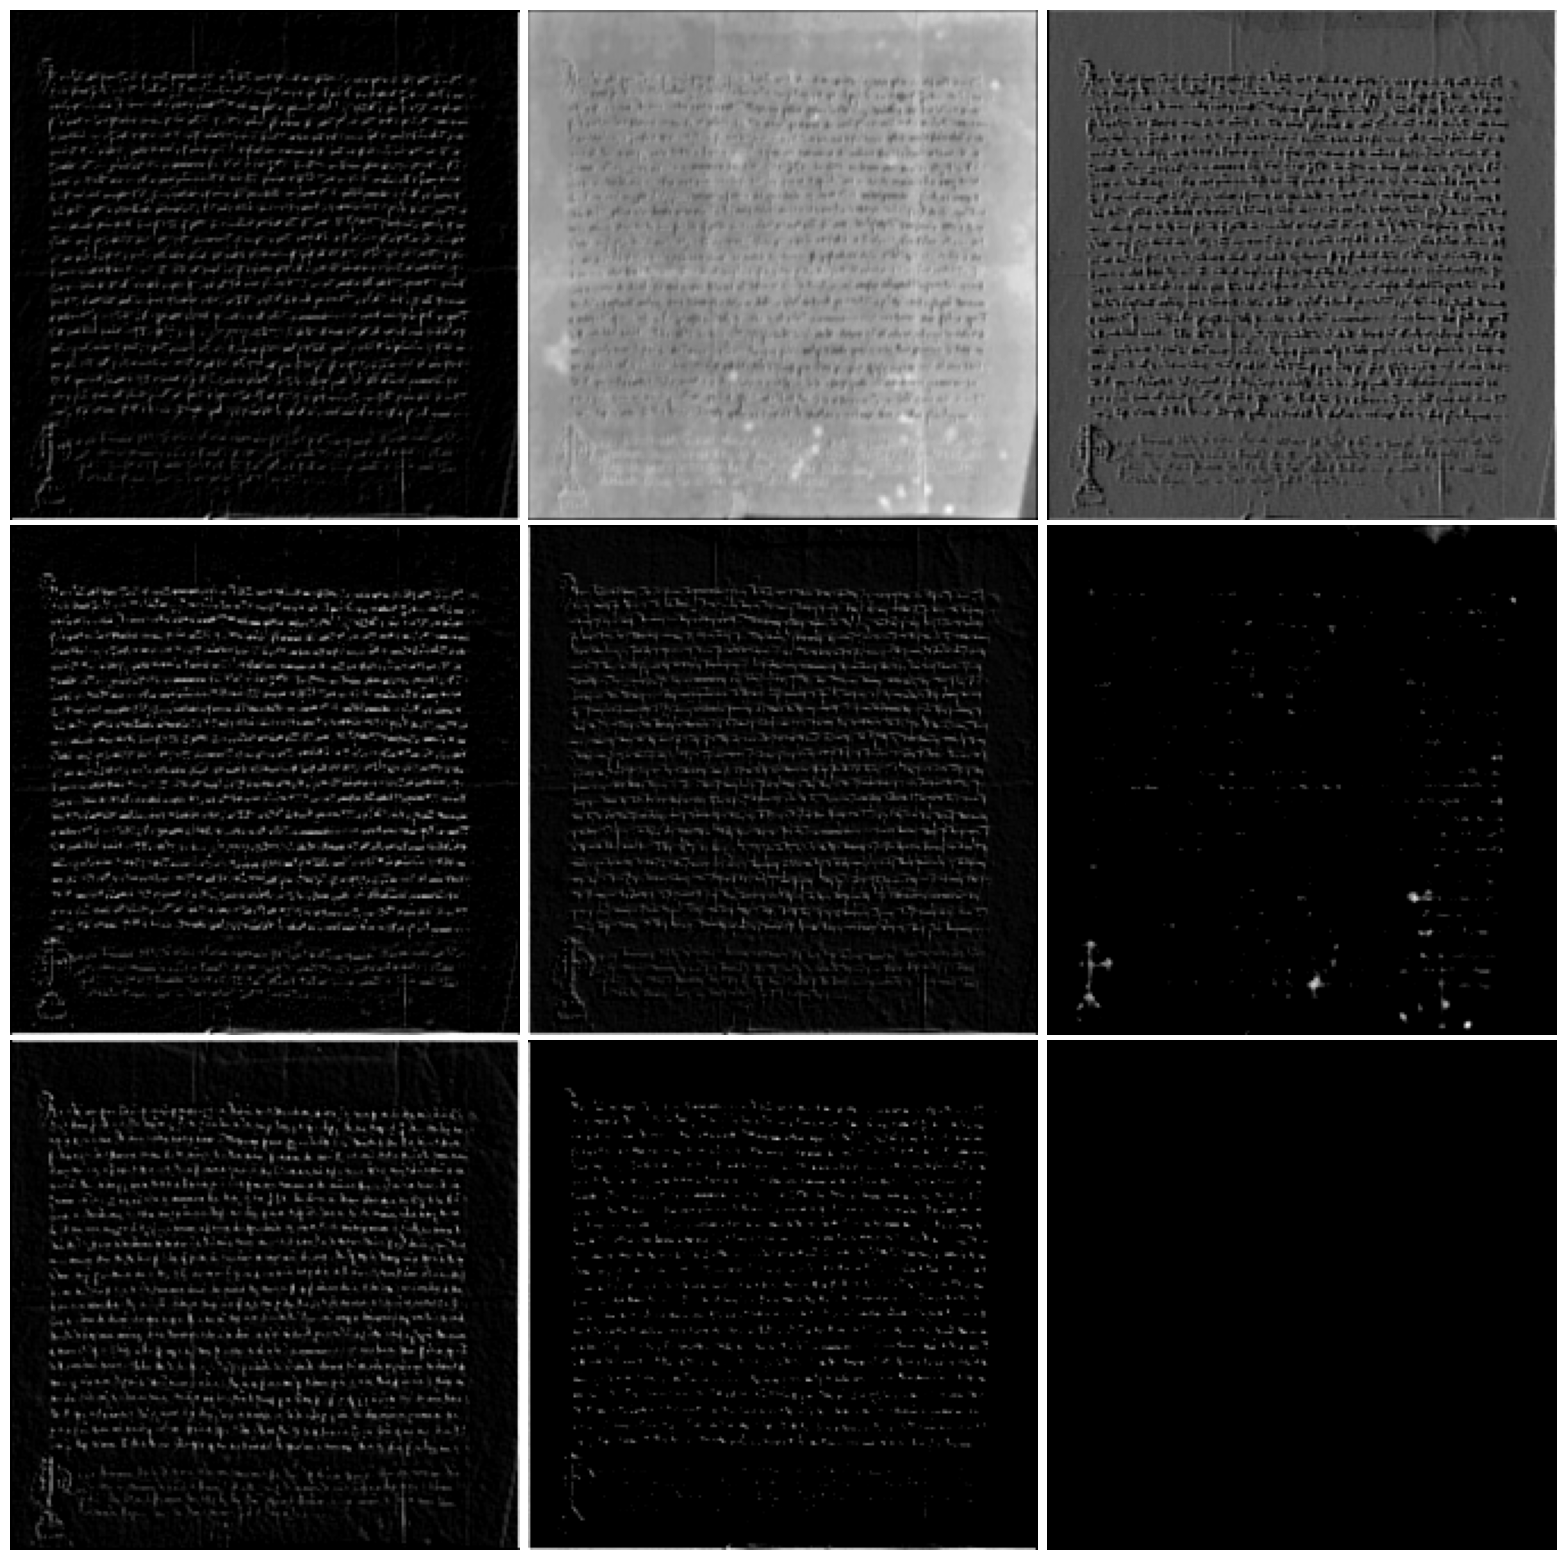

In [9]:
visualize_layer_feature_map(1)


 layer 9 shape: (1, 56, 56, 256)


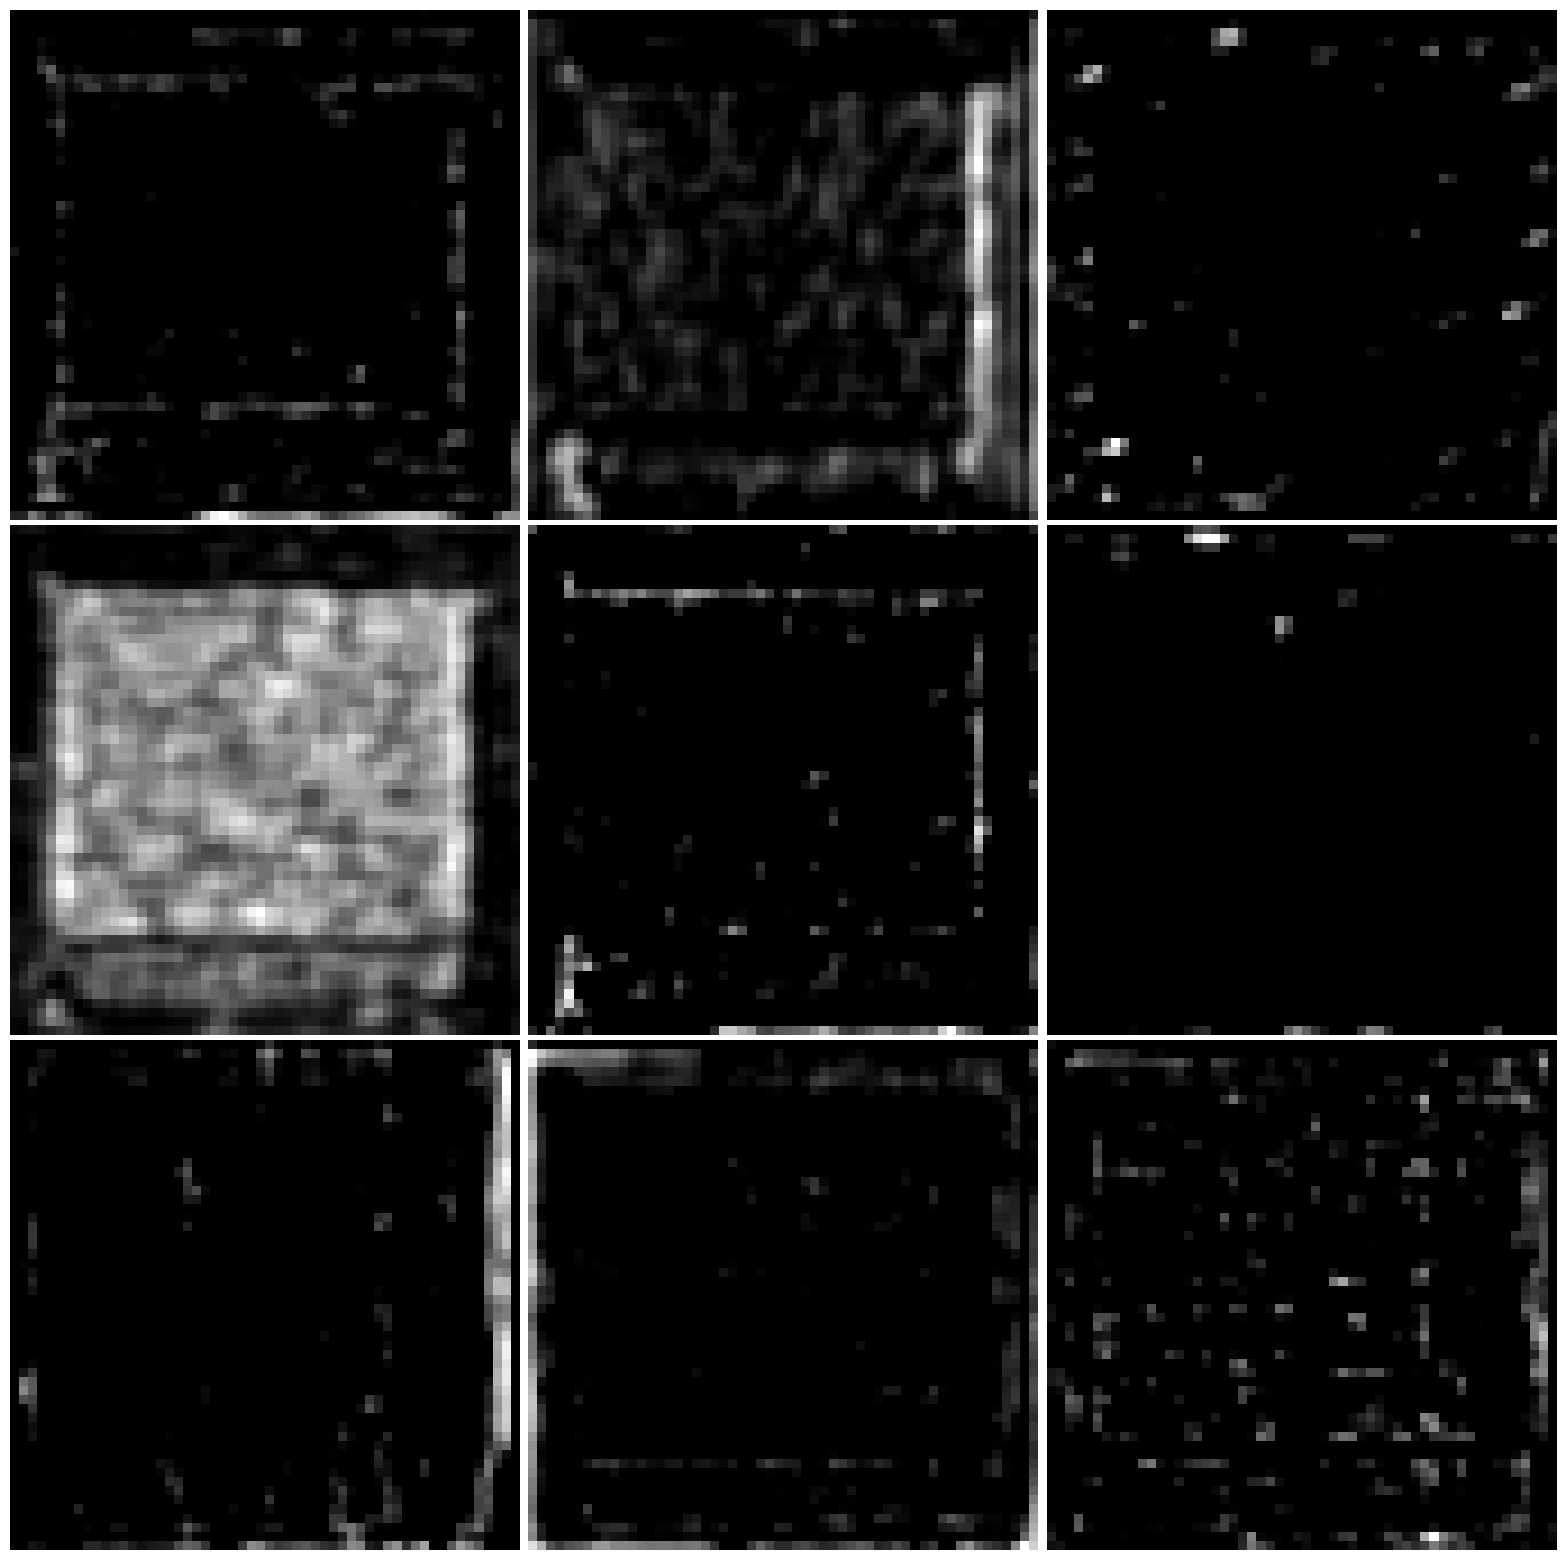

In [10]:
visualize_layer_feature_map(9)


 layer 17 shape: (1, 14, 14, 512)


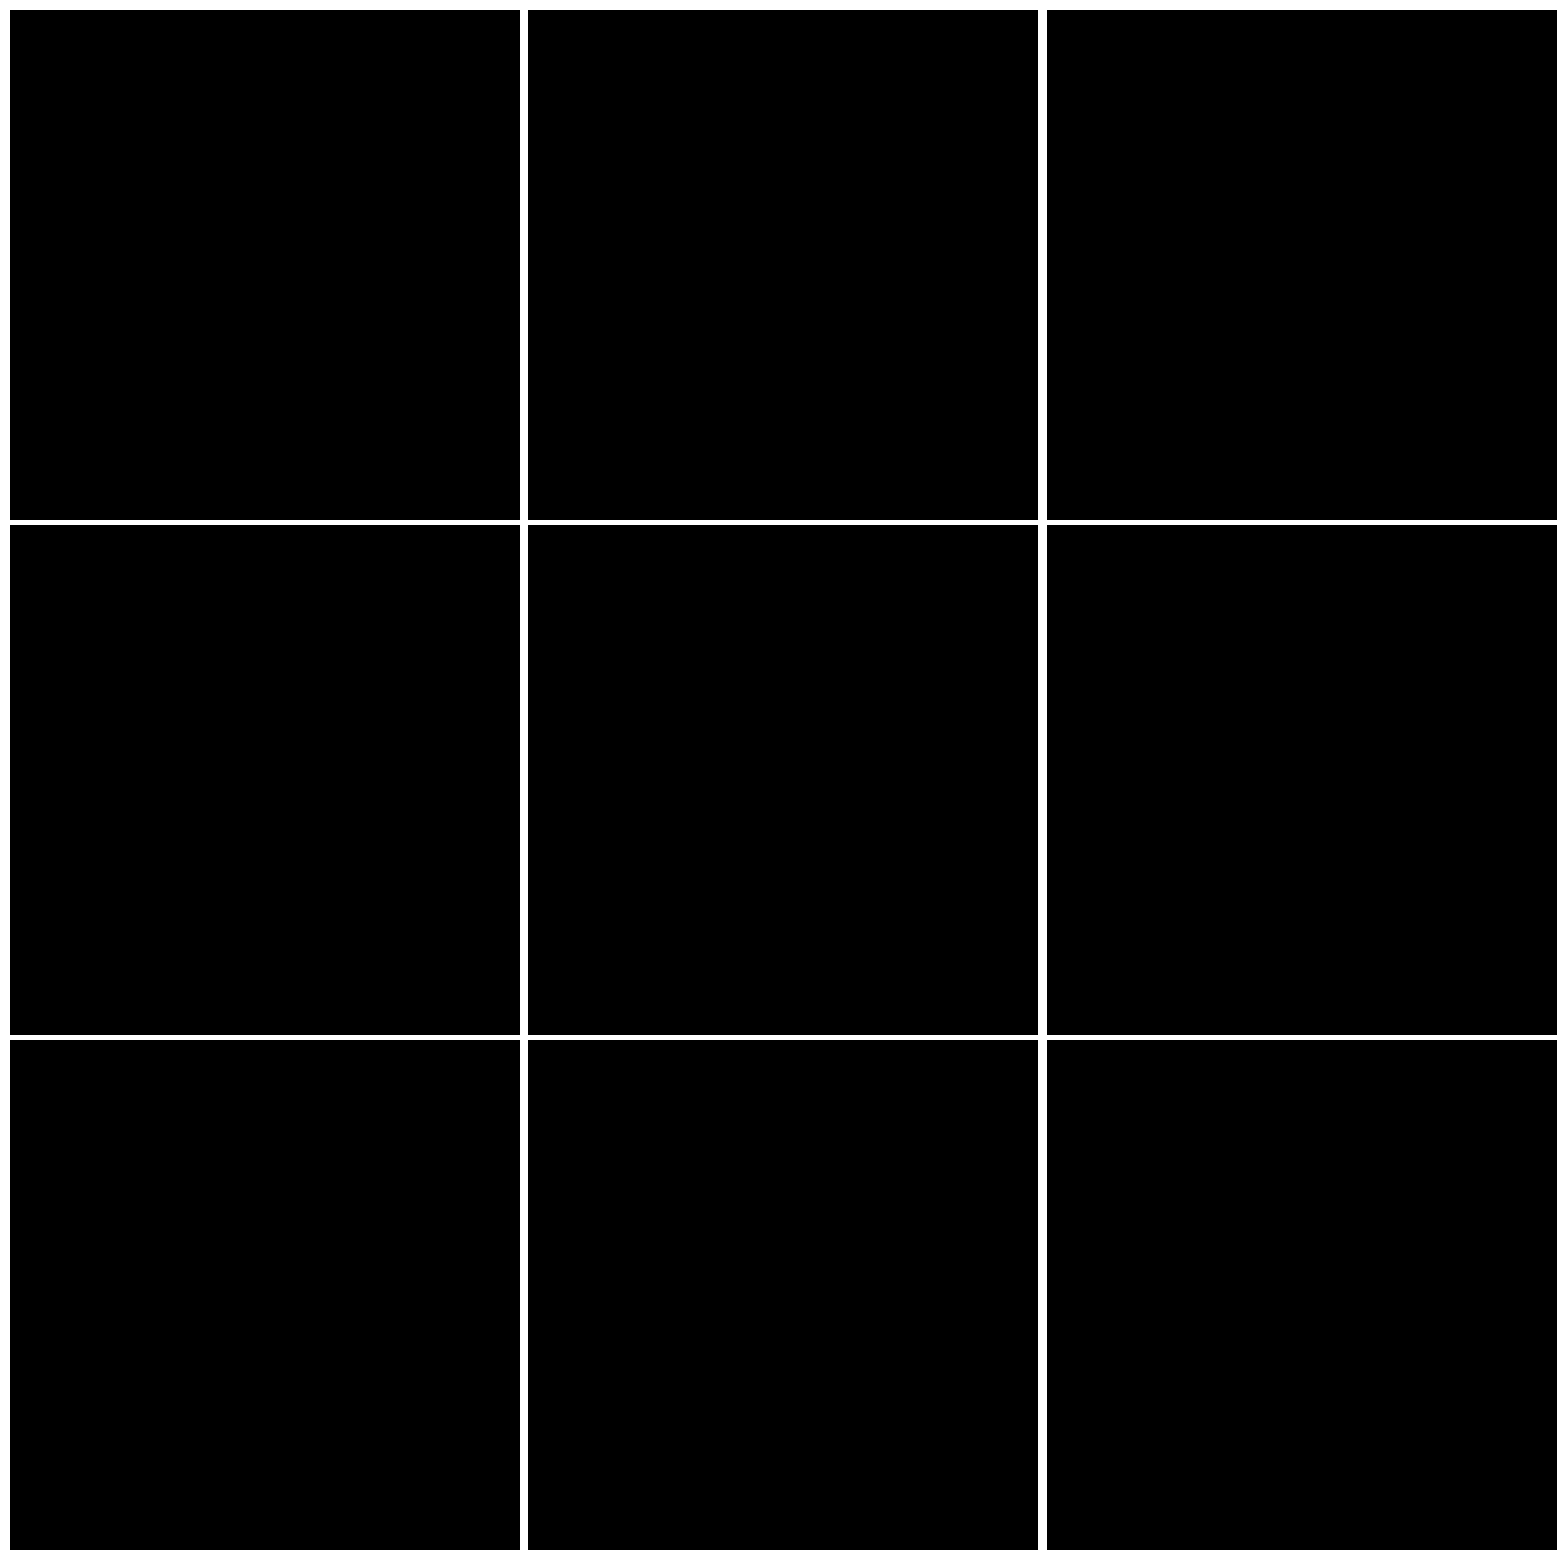

In [11]:
visualize_layer_feature_map(17)

In [12]:
### insert extracted features into dictionary

features = []

# loop through each image in the dataset
for charter in charters:
    # extract the features and update the dictionary
    feat = extract_features_vgg(f'/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/{charter[1]}/{charter[0]}', model_vgg)
    features.append(feat)

1/1 [==============================] - 0s 13ms/step


In [13]:
# squeeze data to remove unneeded dims

features = np.array(features)
features = features.squeeze()
features.shape

(198, 4096)

In [14]:
### export data as pickle file

p = r"/home/tschernn/becore-clustering/features_vgg.pkl"

with open(p,'wb') as file:
    pickle.dump(features, file)
    print(f'Saved features as {file.name}.')

Saved features as /home/tschernn/becore-clustering/features_vgg.pkl.
